In [ ]:
pip install datasets torch transformers

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
import pandas as pd
import torch
from datasets import Dataset
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score

# Read in data
df = pd.read_csv('/content/drive/MyDrive/reviews_with_sentiment.csv')
# Randomly sample 10,000 rows
df = df.sample(n=10000, random_state=42)
df.head()


top_id            date_modified  \
813805   27198  2024-05-20 13:44:21.377   
886734   70775  2024-05-20 10:44:45.803   
122723   31384  2024-05-20 15:04:06.187   
458737   27284  2024-05-20 12:18:59.520   
595877   15577  2024-06-01 19:08:45.953   

                                                     text  sentiment  
813805  did nt have any food a we were on our way back...          1  
886734  the food wa absolute perfection  the himalayan...          1  
122723  loved that their were quite a few vegan option...          1  
458737  thought would be a nice venue a meal out to ce...          1  
595877  great value and experience  rooms have a fridg...          1

In [ ]:
df['sentiment'].value_counts()

sentiment
1    8307
2    1161
0     532
Name: count, dtype: int64

In [ ]:
from imblearn.over_sampling import RandomOverSampler
import numpy as np

ros = RandomOverSampler()
train_x, train_y = ros.fit_resample(np.array(df['text']).reshape(-1, 1), np.array(df['sentiment']).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text', 'sentiment']);
train_os['sentiment'].value_counts()

sentiment
1    8307
2    8307
0    8307
Name: count, dtype: int64

In [ ]:
X = train_os['text'].values
y = train_os['sentiment'].values

In [ ]:
# Split the data into train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    X, y, test_size=0.3, random_state=42)

train_texts = list(map(str, train_texts))
test_texts = list(map(str, test_texts))
# Convert train_labels to a Pandas Series to use value_counts()
train_labels_series = pd.Series(train_labels)
print(train_labels_series.value_counts())

2    5843
1    5808
0    5793
Name: count, dtype: int64


In [ ]:


# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment", num_labels=3) # Specify num_labels for binary classification

# Tokenize the datasets
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128, return_tensors='pt')
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128, return_tensors='pt')

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
train_labels_onehot = enc.fit_transform(train_labels.reshape(-1, 1)).toarray()
test_labels_onehot = enc.transform(test_labels.reshape(-1, 1)).toarray()

# Convert one-hot encoded labels to PyTorch tensors
train_labels = torch.tensor(train_labels_onehot, dtype=torch.float32)  # Use float32 for BCEWithLogitsLoss
test_labels = torch.tensor(test_labels_onehot, dtype=torch.float32)

# Prepare datasets for Trainer
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': train_labels
})

test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'labels': test_labels
})

# Set up Trainer for fine-tuning
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",  # Updated from deprecated 'evaluation_strategy'
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Ensure the model is on the correct device (e.g., GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Fine-tune the model
trainer.train()



config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

TrainOutput(global_step=4362, training_loss=0.3140293717766945, metrics={'train_runtime': 13565.9293, 'train_samples_per_second': 2.572, 'train_steps_per_second': 0.322, 'total_flos': 2294875229423616.0, 'train_loss': 0.3140293717766945, 'epoch': 2.0})

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Evaluate the model
preds = trainer.predict(test_dataset)

# Get predicted class labels
predictions = preds.predictions.argmax(-1)  # Get the index of the highest logit (predicted class)

# Convert test_labels (tensor) to numpy array for compatibility with sklearn metrics
test_labels_np = test_labels.cpu().numpy().argmax(-1)  # Convert one-hot encoded labels back to class labels

# Calculate accuracy and F1 score
accuracy = accuracy_score(test_labels_np, predictions)
f1 = f1_score(test_labels_np, predictions, average='weighted')

# Print the accuracy and F1 score
print(f"Accuracy: {accuracy * 100:.2f}, F1 Score: {f1}")

# Generate and print the classification report
target_names = ['Negative', 'Neutral', 'Positive']  # Adjust these names based on your actual labels
print(classification_report(test_labels_np, predictions, target_names=target_names))


Accuracy: 92.38, F1 Score: 0.9226976562931765
              precision    recall  f1-score   support

    Negative       0.94      1.00      0.97      2514
     Neutral       0.93      0.84      0.88      2499
    Positive       0.90      0.93      0.92      2464

    accuracy                           0.92      7477
   macro avg       0.92      0.92      0.92      7477
weighted avg       0.92      0.92      0.92      7477



In [ ]:
print(f"Accuracy: {accuracy * 100:.2f}, F1 Score: {f1}")

Accuracy: 92.38, F1 Score: 0.9226976562931765


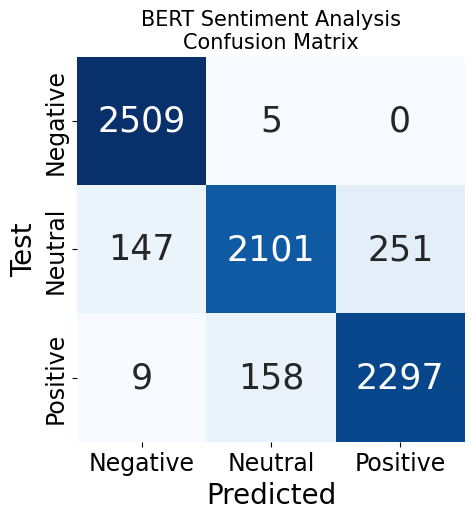

In [ ]:
# Import the necessary function
from sklearn.metrics import confusion_matrix
# Import the necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Generate the confusion matrix
conf_matrix = confusion_matrix(test_labels_np, predictions)
#show confustion matrix
fig, ax =plt.subplots(figsize=(5,5))
labels=['Negative', 'Neutral', 'Positive']
ax=sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
plt.title('BERT Sentiment Analysis\nConfusion Matrix', fontsize=15)
ax.xaxis.set_ticklabels(labels, fontsize=17)
ax.yaxis.set_ticklabels(labels, fontsize=17)
ax.set_ylabel('Test', fontsize=20)
ax.set_xlabel('Predicted', fontsize=20)
plt.show()